In [20]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [50]:
def SplitDataset(classCSVPath):
    mfcc_df = pd.read_csv(classCSVPath)    
    label_encoder = LabelEncoder()
    mfcc_df["Label"] = label_encoder.fit_transform(mfcc_df["Label"])
    
    mfcc_features = mfcc_df.iloc[:, 3:].values  # Extract MFCC features
    spectrogram_paths = mfcc_df["Spectrogram_Path"].values
    labels = mfcc_df["Label"].values
    
    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)
    
    labels_one_hot = to_categorical(labels)
    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, labels_one_hot, range(len(labels)), test_size=0.3, random_state=37
    )
    
    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]
    
    def load_spectrogram_images(paths):
        images = []
        labels = []
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))  # Get base directory (parent of "Code")

        for path in paths:
            corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))  # Convert relative path to absolute
            if os.path.exists(corrected_path):
                img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
                img = img_to_array(img) / 255.0
                images.append(img)
                labels.append(os.path.basename(os.path.dirname(corrected_path)))
            else:
                print(f"Warning: Spectrogram not found at {corrected_path}")  # Debugging print
        
        return np.array(images), labels

    
    X_train_spectrogram, spectrogram_train_labels = load_spectrogram_images(X_train_spectrogram_paths)
    X_test_spectrogram, spectrogram_test_labels = load_spectrogram_images(X_test_spectrogram_paths)
    
    spectrogram_train_labels = label_encoder.transform(spectrogram_train_labels)
    spectrogram_test_labels = label_encoder.transform(spectrogram_test_labels)
    
    y_train_spectrogram = to_categorical(spectrogram_train_labels)
    y_test_spectrogram = to_categorical(spectrogram_test_labels)
    
    return X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, label_encoder


In [51]:
base_audio_path = "C:/Users/HP/Downloads/Project/Dataset/base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder = SplitDataset(base_audio_path)

In [52]:
# Print sample output
print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label


Sample MFCC Features Shape: (144, 13, 1)
Sample Spectrogram Image Shape: (144, 224, 224, 3)
Sample Label One-Hot: [0. 1. 0. 0.]
Sample Label One-Hot: [0. 1. 0. 0.]


## MFCC Models

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

### CNN

In [54]:
# Define CNN Model with Regularization and Batch Normalization
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_mfcc.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer
])

cnn_model.summary()


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,244 (133.77 KB)

 Trainable params: 33,860 (132.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [55]:
# Compile CNN Model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping Callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN Model
cnn_history = cnn_model.fit(X_train_mfcc, y_train_mfcc, 
                            epochs=30, 
                            batch_size=32, 
                            validation_data=(X_test_mfcc, y_test_mfcc))
                            # callbacks=[early_stopping])


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5565 - loss: 1.4157 - val_accuracy: 0.7569 - val_loss: 1.4063
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8842 - loss: 0.6711 - val_accuracy: 0.8681 - val_loss: 1.3536
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9188 - loss: 0.4168 - val_accuracy: 0.8889 - val_loss: 1.3328
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9528 - loss: 0.3232 - val_accuracy: 0.8750 - val_loss: 1.3271
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9551 - loss: 0.3122 - val_accuracy: 0.7708 - val_loss: 1.3225
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9616 - loss: 0.3228 - val_accuracy: 0.7986 - val_loss: 1.3024
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9400 - loss: 0.3046 - val_accuracy: 0.7847 - val_loss: 1.2758
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9790 - loss: 0.2706 - val_accuracy: 0.8333 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9497 - loss: 0.3778 


CNN Training Accuracy: 99.11%
CNN Test Accuracy: 95.83%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


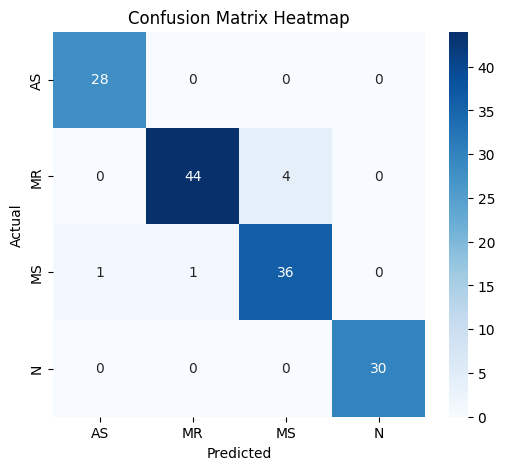

Classification Report:
               precision    recall  f1-score   support

          AS       0.97      1.00      0.98        28
          MR       0.98      0.92      0.95        48
          MS       0.90      0.95      0.92        38
           N       1.00      1.00      1.00        30

    accuracy                           0.96       144
   macro avg       0.96      0.97      0.96       144
weighted avg       0.96      0.96      0.96       144



In [56]:
# Evaluate CNN Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_mfcc, y_test_mfcc)
print(f"CNN Training Accuracy: {max(cnn_history.history['accuracy']) * 100:.2f}%")
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

# Saving the Model
cnn_model.save("mfcc_cnn_model.h5")

# Predictions
y_pred = cnn_model.predict(X_test_mfcc)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_mfcc, axis=1)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

### LSTM Model


In [64]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [65]:
# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_mfcc.shape[1], 1), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer with softmax activation
])
lstm_model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,340 (212.27 KB)

 Trainable params: 54,340 (212.27 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Compile LSTM Model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM Model
lstm_history = lstm_model.fit(X_train_mfcc, y_train_mfcc, epochs=30, batch_size=32, validation_data=(X_test_mfcc, y_test_mfcc))

# Extract Training Accuracy
train_accuracy = lstm_history.history['accuracy'][-1]  # Last epoch's training accuracy

# Evaluate LSTM Model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_mfcc, y_test_mfcc)

# Print Training and Test Accuracy
print(f"LSTM Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"LSTM Test Accuracy: {lstm_accuracy * 100:.2f}%")

# Save the model
lstm_model.save("mfcc_LSTM_Model.h5")

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4668 - loss: 1.3509 - val_accuracy: 0.8472 - val_loss: 1.2269
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7279 - loss: 1.1844 - val_accuracy: 0.8681 - val_loss: 0.9456
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6860 - loss: 0.9270 - val_accuracy: 0.8819 - val_loss: 0.6745
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8374 - loss: 0.5769 - val_accuracy: 0.8819 - val_loss: 0.5453
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8811 - loss: 0.4273 - val_accuracy: 0.8889 - val_loss: 0.4682
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9072 - loss: 0.3584 - val_accuracy: 0.9306 - val_loss: 0.3965
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9414 - loss: 0.2809 - val_accuracy: 0.9236 - val_loss: 0.3707
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9555 - loss: 0.2187 - val_accuracy: 0.9306 - v

LSTM Training Accuracy: 97.62%
LSTM Test Accuracy: 96.53%


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


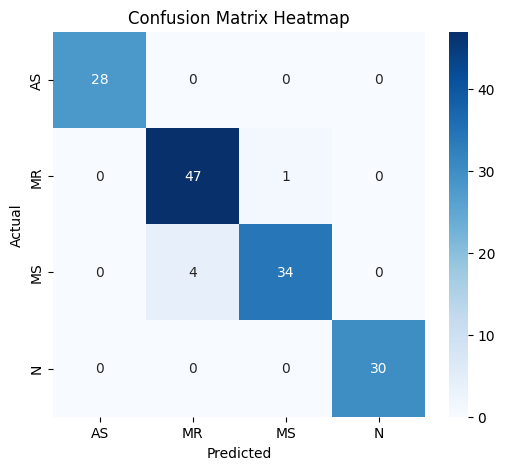

Classification Report:
               precision    recall  f1-score   support

          AS       1.00      1.00      1.00        28
          MR       0.92      0.98      0.95        48
          MS       0.97      0.89      0.93        38
           N       1.00      1.00      1.00        30

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



In [67]:

# Predict on test data
y_pred = lstm_model.predict(X_test_mfcc)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels to original labels
y_test_labels = np.argmax(y_test_mfcc, axis=1)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot heatmap for confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))


### BiLSTM Model


In [68]:
from tensorflow.keras.layers import Bidirectional

In [73]:
# BiLSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_mfcc.shape[1], 1)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer with softmax activation
])
bilstm_model.summary()



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 13, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,124 (551.27 KB)

 Trainable params: 141,124 (551.27 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Compile BiLSTM Model
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train BiLSTM Model
bilstm_history = bilstm_model.fit(X_train_mfcc, y_train_mfcc, epochs=30, batch_size=32, validation_data=(X_test_mfcc, y_test_mfcc))

# Evaluate BiLSTM Model
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test_mfcc, y_test_mfcc)

# Print Training & Testing Accuracy
print(f"BiLSTM Training Accuracy: {max(bilstm_history.history['accuracy']) * 100:.2f}%")
print(f"BiLSTM Test Accuracy: {bilstm_accuracy * 100:.2f}%")

#Saving the Model
bilstm_model.save("mfcc_BiLSTM_Model.h5")


Epoch 1/30


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5185 - loss: 1.3191 - val_accuracy: 0.8125 - val_loss: 1.0607
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7177 - loss: 0.9432 - val_accuracy: 0.8194 - val_loss: 0.7308
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7833 - loss: 0.6939 - val_accuracy: 0.8819 - val_loss: 0.5657
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8245 - loss: 0.4700 - val_accuracy: 0.8958 - val_loss: 0.4569
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9015 - loss: 0.3700 - val_accuracy: 0.9236 - val_loss: 0.3576
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9431 - loss: 0.2532 - val_accuracy: 0.9167 - val_loss: 0.3191
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9235 - loss: 0.2740 - val_accuracy: 0.9375 - val_loss: 0.2736
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9504 - loss: 0.1791 - val_accuracy: 0.9306 - val_loss: 0.

BiLSTM Training Accuracy: 99.11%
BiLSTM Test Accuracy: 98.61%


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.98      0.98      0.98        48
           2       0.97      0.97      0.97        38
           3       1.00      1.00      1.00        30

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



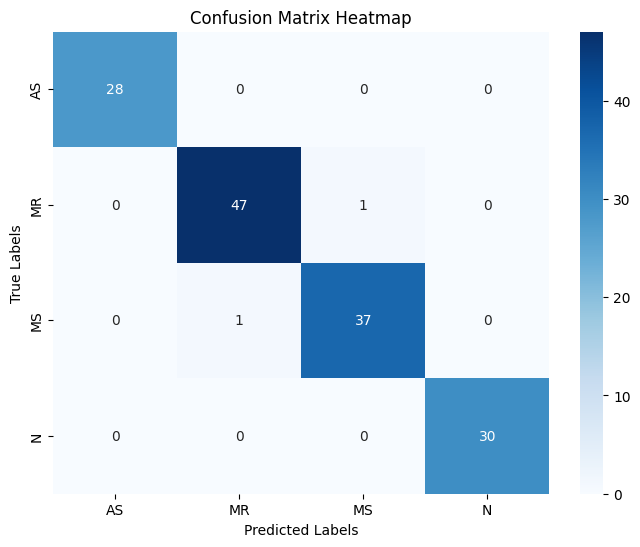

In [77]:
# Generate Predictions
y_pred_probs = bilstm_model.predict(X_test_mfcc)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test_mfcc, axis=1)  # Convert one-hot encoding back to class labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Heatmap for Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Random Forest


In [80]:
from sklearn.ensemble import RandomForestClassifier
import joblib

Training Accuracy: 100.00%
Test Accuracy: 95.83%

Classification Report:
               precision    recall  f1-score   support

          AS       0.90      1.00      0.95        28
          MR       0.98      0.98      0.98        48
          MS       0.97      0.89      0.93        38
           N       1.00      1.00      1.00        30

    accuracy                           0.97       144
   macro avg       0.96      0.97      0.96       144
weighted avg       0.97      0.97      0.97       144


Confusion Matrix:
 [[28  0  0  0]
 [ 0 47  1  0]
 [ 3  1 34  0]
 [ 0  0  0 30]]


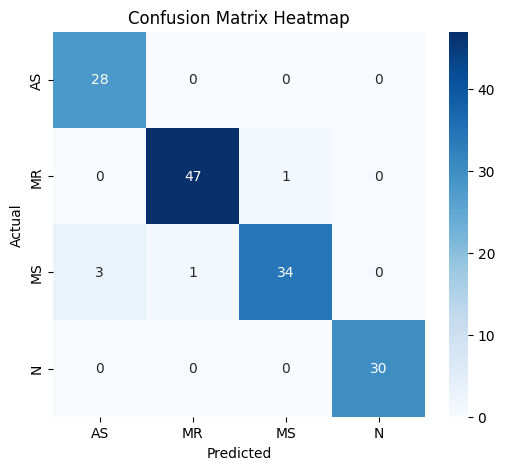

In [87]:
# Reshape the input data from (num_samples, num_timesteps, num_features) to (num_samples, num_timesteps * num_features)
X_train_mfcc_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)
X_test_mfcc_reshaped = X_test_mfcc.reshape(X_test_mfcc.shape[0], -1)


# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_mfcc_reshaped, y_train_mfcc)

# Predict on test set
y_pred = rf_model.predict(X_test_mfcc_reshaped)

# Calculate training accuracy
y_train_pred = rf_model.predict(X_train_mfcc_reshaped)
train_accuracy = accuracy_score(y_train_mfcc, y_train_pred)

# Evaluate model
accuracy = accuracy_score(y_test_mfcc, y_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
joblib.dump(rf_model, 'mfcc_rf_model.pkl')

y_test_mfcc_re = np.argmax(y_test_mfcc, axis=1)
y_pred_re = np.argmax(y_pred, axis=1)


# Display classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test_mfcc_re, y_pred_re, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_mfcc_re, y_pred_re))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test_mfcc_re, y_pred_re)

# Plot heatmap for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()



### Decision Tree Model

In [88]:
from sklearn.tree import DecisionTreeClassifier

Decision Tree Training Accuracy: 100.00%
Decision Tree Test Accuracy: 95.83%


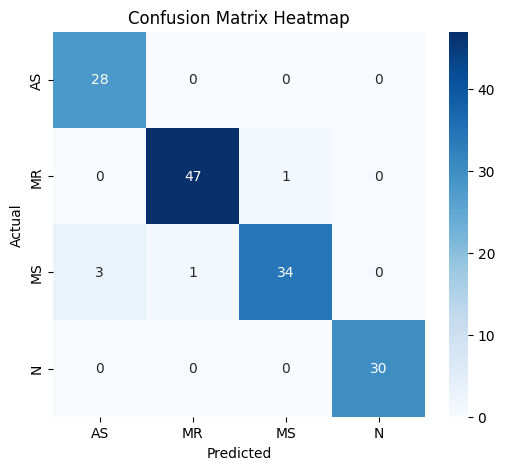

Classification Report:
               precision    recall  f1-score   support

          AS       0.90      1.00      0.95        28
          MR       0.98      0.98      0.98        48
          MS       0.97      0.89      0.93        38
           N       1.00      1.00      1.00        30

    accuracy                           0.97       144
   macro avg       0.96      0.97      0.96       144
weighted avg       0.97      0.97      0.97       144



In [92]:
# Decision Tree Model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train Decision Tree Model
decision_tree_model.fit(X_train_mfcc_reshaped, y_train_mfcc)

# Predict on training data
y_train_pred = decision_tree_model.predict(X_train_mfcc_reshaped)

# Predict on test data
y_pred = decision_tree_model.predict(X_test_mfcc_reshaped)

# Calculate Training and Test Accuracy
train_accuracy = accuracy_score(y_train_mfcc, y_train_pred)
test_accuracy = accuracy_score(y_test_mfcc, y_pred)

print(f"Decision Tree Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Decision Tree Test Accuracy: {test_accuracy * 100:.2f}%")

# save the model
joblib.dump(decision_tree_model, 'mfcc_decision_tree_model.pkl')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test_mfcc_re, y_pred_re)

# Plot heatmap for confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test_mfcc_re, y_pred_re, target_names=label_encoder.classes_))


## Spectrogram Models

### MobileNet

In [83]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential

In [84]:
# Load the pre-trained MobileNet model
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
mobilenet_base.trainable = False

# Build the model on top of MobileNet
model_mobilenet = Sequential([
    mobilenet_base,  # Use MobileNet as the base
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# mobilenet_base.summary()

model_mobilenet.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,580 (12.82 MB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [85]:
# Compile the model
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_mobilenet = model_mobilenet.fit(X_train_spec, y_train_spec, epochs=30, batch_size=32, validation_data=(X_test_spec, y_test_spec))

# Evaluate the model
test_loss_mobilenet, test_accuracy_mobilenet = model_mobilenet.evaluate(X_test_spec, y_test_spec)
print(f"Test Accuracy for MobileNet: {test_accuracy_mobilenet * 100:.2f}%")

# Save the model
model_mobilenet.save("spec_mobilenet_model.h5")

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.4486 - loss: 1.4216 - val_accuracy: 0.9167 - val_loss: 0.4621
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.7878 - loss: 0.5586 - val_accuracy: 0.9514 - val_loss: 0.2524
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 0.9084 - loss: 0.2980 - val_accuracy: 0.9514 - val_loss: 0.2378
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - accuracy: 0.9499 - loss: 0.1856 - val_accuracy: 0.9653 - val_loss: 0.1367
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9623 - loss: 0.1510

KeyboardInterrupt: 

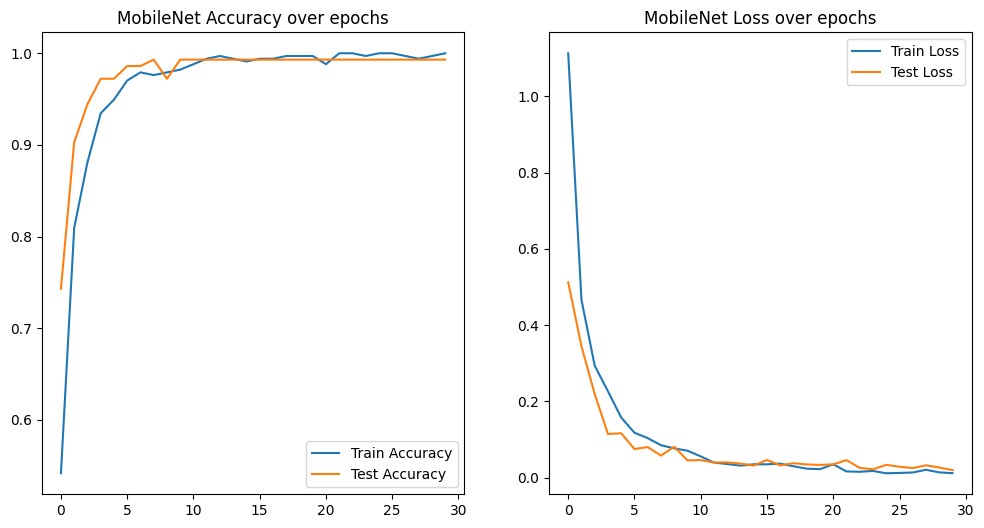

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Test Accuracy')
plt.title('MobileNet Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Test Loss')
plt.title('MobileNet Loss over epochs')
plt.legend()

plt.show()

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/stepWARNING:tensorflow:5 out of the last 22 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025CC6F3AE80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step


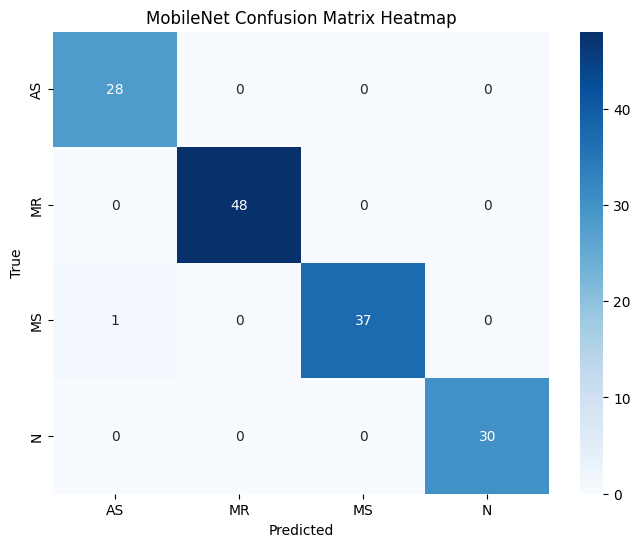

In [ ]:
# Predict on the test set
y_pred_mobilenet = model_mobilenet.predict(X_test_spec)
y_pred_mobilenet = np.argmax(y_pred_mobilenet, axis=1)  # Convert predictions from probabilities to class labels

y_test_spec_int = np.argmax(y_test_spec, axis=1)  # Convert from one-hot encoding to integer labels

cm_mobilenet = confusion_matrix(y_test_spec_int, y_pred_mobilenet)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('MobileNet Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### EfficientNet

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D

In [43]:
# Load the pre-trained EfficientNetB0 model
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
efficientnet_base.trainable = False

# Build the model on top of EfficientNetB0
model_efficientnet = Sequential([
    efficientnet_base,  # Use EfficientNetB0 as the base
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model_efficientnet.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,787 (41.89 MB)

 Trainable params: 197,252 (770.52 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [45]:
# Compile the model
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnet = model_efficientnet.fit(X_train_spec, y_train_spec, epochs=30, batch_size=32, validation_data=(X_test_spec, y_test_spec))

# Evaluate the model
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet.evaluate(X_test_spec, y_test_spec)
print(f"Test Accuracy for EfficientNet: {test_accuracy_efficientnet * 100:.2f}%")

# Save the model
model_efficientnet.save("spec_efficientnet_model.h5")

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2341 - loss: 1.5068 - val_accuracy: 0.1875 - val_loss: 1.4929
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2804 - loss: 1.4578 - val_accuracy: 0.3021 - val_loss: 1.3908
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3041 - loss: 1.3752 - val_accuracy: 0.2708 - val_loss: 1.3823
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2573 - loss: 1.4102 - val_accuracy: 0.1875 - val_loss: 1.3884
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2813 - loss: 1.3867 - val_accuracy: 0.1875 - val_loss: 1.3996
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2324 - loss: 1.3980 - val_accuracy: 0.1875 - val_loss: 1.3922
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2791 - loss: 1.3855 - val_accuracy: 0.1875 - val_loss: 1.3919
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2563 - loss: 1.3852 - val_accuracy: 0.1875 - val_loss:

Test Accuracy for EfficientNet: 18.75%


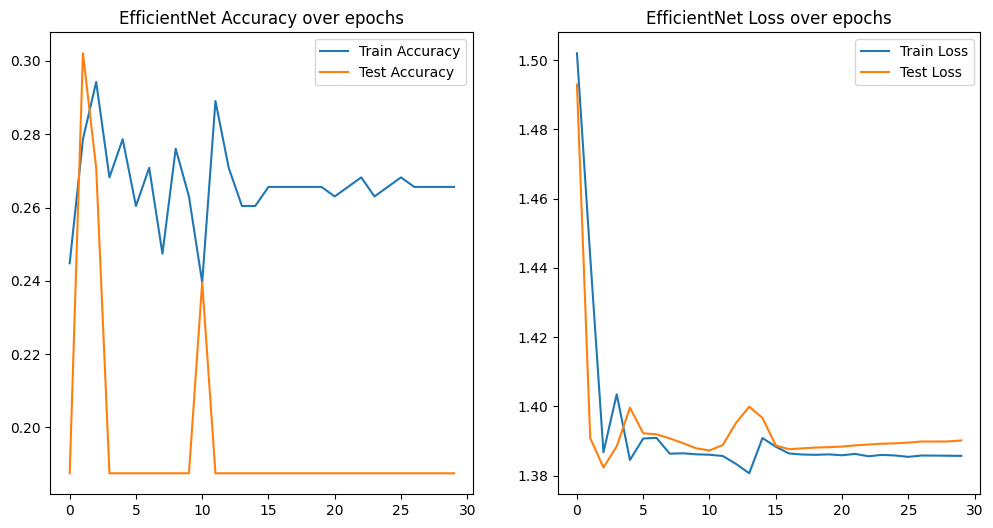

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 868ms/step


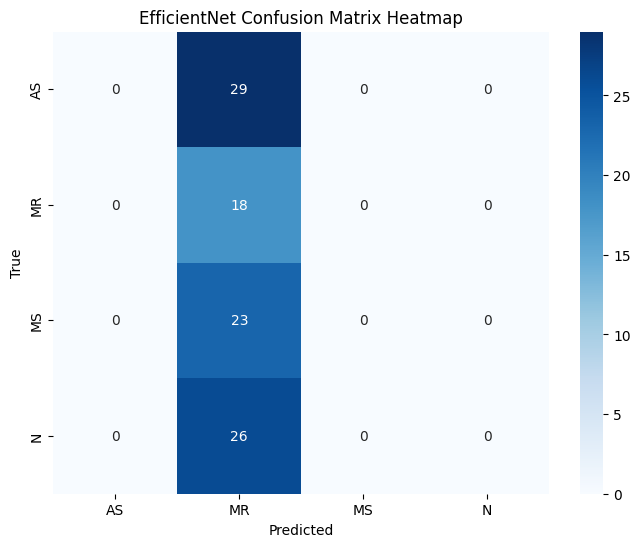

In [49]:
# Visualize training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Test Accuracy')
plt.title('EfficientNet Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Test Loss')
plt.title('EfficientNet Loss over epochs')
plt.legend()

plt.show()

# Predict on the test set
y_pred_efficientnet = model_efficientnet.predict(X_test_spec)
y_pred_efficientnet = np.argmax(y_pred_efficientnet, axis=1)  # Convert predictions from probabilities to class labels

y_test_spec_int = np.argmax(y_test_spec, axis=1)  # Convert from one-hot encoding to integer labels

cm_efficientnet = confusion_matrix(y_test_spec_int, y_pred_efficientnet)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_efficientnet, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('EfficientNet Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ResNet Model

In [94]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [95]:
# Load the pre-trained ResNet50 model, excluding the top layers for fine-tuning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the complete model
model = models.Sequential([
    base_model,  # Add the ResNet base model
    layers.GlobalAveragePooling2D(),  # Pooling to reduce the spatial dimensions
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model.summary()



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,108 (90.48 MB)

 Trainable params: 131,396 (513.27 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [97]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_spec, y_train_spec, epochs=30, batch_size=32, validation_data=(X_test_spec, y_test_spec))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_spec, y_test_spec)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("spectrogram_resnet_model.h5")

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2555 - loss: 1.5514 - val_accuracy: 0.2083 - val_loss: 1.3893
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2773 - loss: 1.4039 - val_accuracy: 0.5139 - val_loss: 1.3666
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3496 - loss: 1.3473 - val_accuracy: 0.5694 - val_loss: 1.3696
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4272 - loss: 1.3254 - val_accuracy: 0.4167 - val_loss: 1.3419
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3620 - loss: 1.3290 - val_accuracy: 0.3472 - val_loss: 1.3344
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3773 - loss: 1.3064 - val_accuracy: 0.4444 - val_loss: 1.3255
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4342 - loss: 1.2897 - val_accuracy: 0.4028 - val_loss: 1.3378
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4079 - loss: 1.2752 - val_accuracy: 0.3958 - val_loss:

Test Accuracy: 58.33%


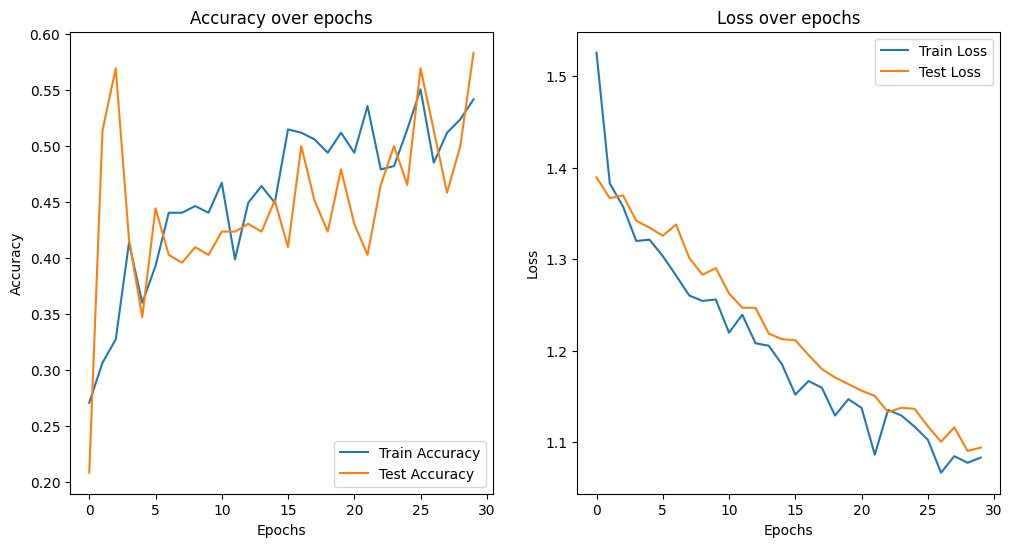

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 744ms/step


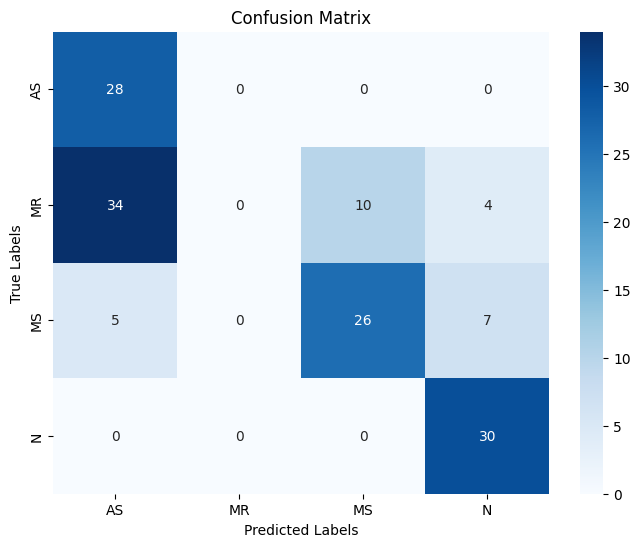

              precision    recall  f1-score   support

          AS       0.42      1.00      0.59        28
          MR       0.00      0.00      0.00        48
          MS       0.72      0.68      0.70        38
           N       0.73      1.00      0.85        30

    accuracy                           0.58       144
   macro avg       0.47      0.67      0.53       144
weighted avg       0.42      0.58      0.48       144



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [100]:
# Visualize training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix
y_pred = model.predict(X_test_spec)
y_pred_labels = np.argmax(y_pred, axis=1)

y_test_spec_re = np.argmax(y_test_spec, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_spec_re, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_report = classification_report(y_test_spec_re, y_pred_labels, target_names=label_encoder.classes_)
print(class_report)



### RNN Model


### CNN Model


In [101]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [102]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_spec, y_train_spec, epochs=30, batch_size=32, validation_data=(X_test_spec, y_test_spec))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_spec, y_test_spec)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("spectrogram_cnn_model.h5")


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.3814 - loss: 2.1498 - val_accuracy: 0.6181 - val_loss: 0.8889
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 488ms/step - accuracy: 0.7256 - loss: 0.7245 - val_accuracy: 0.9028 - val_loss: 0.2993
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - accuracy: 0.8805 - loss: 0.3577 - val_accuracy: 0.9583 - val_loss: 0.0902
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.9350 - loss: 0.1871 - val_accuracy: 0.9653 - val_loss: 0.0990
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - accuracy: 0.9263 - loss: 0.1574 - val_accuracy: 0.9722 - val_loss: 0.0445
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 540ms/step - accuracy: 0.9720 - loss: 0.0626 - val_accuracy: 0.9861 - val_loss: 0.0395
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step - accuracy: 0.9748 - loss: 0.0840 - val_accuracy: 0.9722 - val_loss: 0.0926
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 0.9940 - loss: 0.0460 - val_accuracy: 0.

Test Accuracy: 99.31%


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


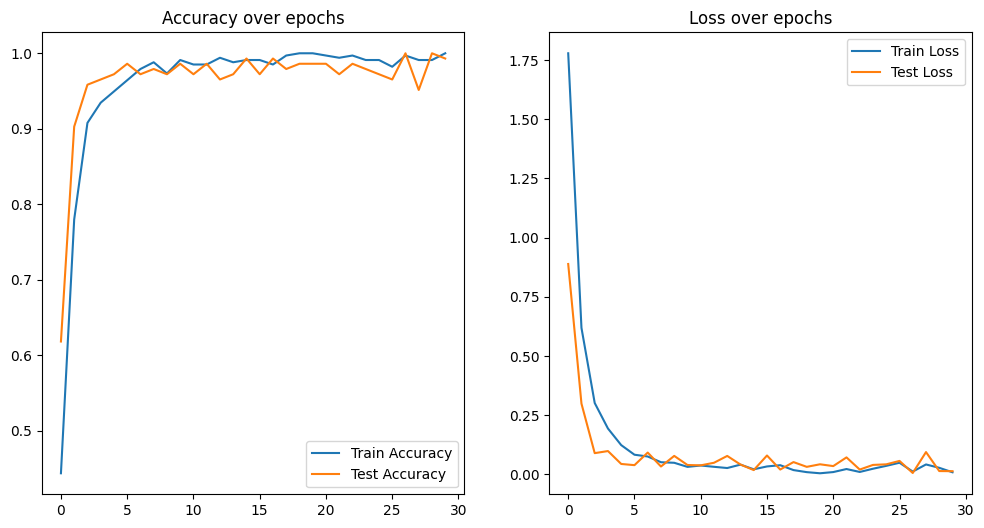

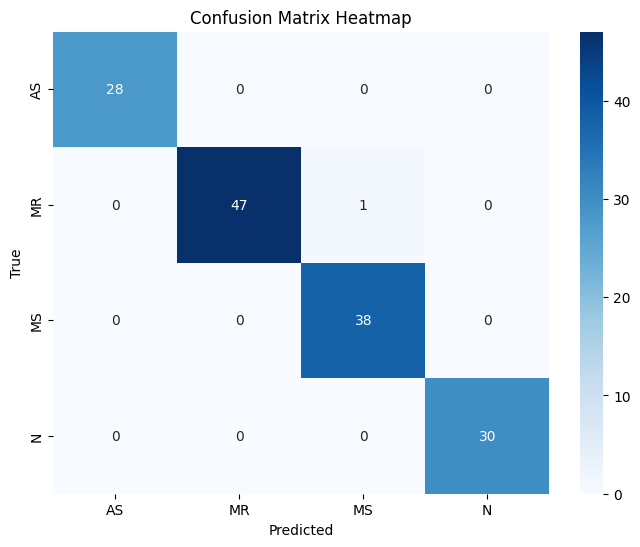

In [105]:
# Visualize training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.legend()

# plt.show()

# Predict on the test set
y_pred = model.predict(X_test_spec)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions from probabilities to class labels

# Confusion Matrix
cm = confusion_matrix(y_test_spec_re, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Ensemble

In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the trained MFCC models
mfcc_model_1 = tf.keras.models.load_model(r"C:\Users\HP\Downloads\Project\Code\MFCC_H5\mfcc_BiLSTM_Model.h5")
mfcc_model_2 = tf.keras.models.load_model(r"C:\Users\HP\Downloads\Project\Code\MFCC_H5\mfcc_cnn_model.h5")
mfcc_model_3 = joblib.load(r"C:\Users\HP\Downloads\Project\Code\MFCC_H5\mfcc_decision_tree_model.pkl")
mfcc_model_4 = tf.keras.models.load_model(r"C:\Users\HP\Downloads\Project\Code\MFCC_H5\mfcc_LSTM_Model.h5")
mfcc_model_5 = joblib.load(r"C:\Users\HP\Downloads\Project\Code\MFCC_H5\mfcc_rf_model.pkl")

# Define weights for each model (based on validation accuracy)
mfcc_weights = [0.35, 0.35, 0.05, 0.2, 0.05]  # Adjust based on performance

def get_mfcc_ensemble_prediction(models, weights, X_test):
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  
    num_classes = 4  # Ensure we have 4 classes

    predictions = []
    for model in models:
        if isinstance(model, tf.keras.Model):  # TensorFlow models
            pred = model.predict(X_test)  # Already one-hot encoded
        else:  # Scikit-Learn models (Decision Tree, Random Forest)
            pred = model.predict(X_test_reshaped)  # Output class labels
            pred = np.round(pred).astype(int)  # Ensure integer class labels
            pred = np.eye(num_classes)[pred]  # Convert to one-hot encoding
        
        predictions.append(pred)  # Ensure uniform array format

    predictions = np.array(predictions)  # Shape: (num_models, num_samples, num_classes)
    weighted_predictions = np.average(predictions, axis=0, weights=weights)  # Weighted ensemble
    return np.argmax(weighted_predictions, axis=1)  # Return final class labels


# Get MFCC ensemble predictions
mfcc_models = [mfcc_model_1, mfcc_model_2, mfcc_model_3, mfcc_model_4, mfcc_model_5]
mfcc_predictions = get_mfcc_ensemble_prediction(mfcc_models, mfcc_weights, X_test_mfcc)

# Load the trained Spectrogram models
spec_model_1 = tf.keras.models.load_model(r"C:\Users\HP\Downloads\Project\Code\Spec_H5\spec_mobilenet_model.h5")
spec_model_2 = tf.keras.models.load_model(r"C:\Users\HP\Downloads\Project\Code\Spec_H5\spectrogram_cnn_model.h5")

# Define weights for each model (based on validation accuracy)
spec_weights = [0.55, 0.45]  # Adjust based on model performance

def get_spec_ensemble_prediction(models, weights, X_test):
    predictions = np.array([model.predict(X_test) for model in models])  # Shape: (num_models, num_samples, num_classes)
    weighted_preds = np.average(predictions, axis=0, weights=weights)  # Weighted average
    final_preds = np.argmax(weighted_preds, axis=1)  # Get class with highest probability
    return final_preds

# Get Spectrogram ensemble predictions
spec_models = [spec_model_1, spec_model_2]
spec_predictions = get_spec_ensemble_prediction(spec_models, spec_weights, X_test_spec)

# Stack MFCC and Spectrogram predictions as input for the meta-model
X_meta_train = np.column_stack((mfcc_predictions, spec_predictions))  # Shape: (num_samples, 2)
y_meta_train = y_test_mfcc  # Use the true labels as targets for training the meta-model

# Define and train the meta-model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

# Predict on the training data
meta_predictions_train = meta_model.predict(X_meta_train)

# Evaluate meta-model
accuracy = accuracy_score(y_meta_train, meta_predictions_train)
print(f"Meta-Model Training Accuracy: {accuracy*100 :.2f}%")

# Generate test predictions from MFCC and Spectrogram models
mfcc_predictions_test = get_mfcc_ensemble_prediction(mfcc_models, mfcc_weights, X_test_mfcc)
spec_predictions_test = get_spec_ensemble_prediction(spec_models, spec_weights, X_test_spec)

# Stack predictions for the meta-model
X_meta_test = np.column_stack((mfcc_predictions_test, spec_predictions_test))  # Shape: (num_samples, 2)

# Get final predictions from meta-model
final_predictions = meta_model.predict(X_meta_test)

# Evaluate final ensemble model
final_accuracy = accuracy_score(y_test_mfcc, final_predictions)
print(f"Final Ensemble Model Accuracy: {final_accuracy*100 :.2f}%")

# Save the meta-model
joblib.dump(meta_model, 'meta_model.pkl')


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (5, 144, 4) + inhomogeneous part.